# Influence of Load Introduction Method

In [1]:
# Import settings and constants
import os   # module for interfacing with the underlying operating system
import sys  # module for interacting with the Python interpreter
parent_directory = os.path.join(os.path.dirname(os.getcwd()))
sys.path.append(parent_directory)
from settings import *

# Define name of directory where to save analyses and figures
FIGURES_DIRECTORY_PATH = os.getcwd()
DATA_DIRECTORY_PATH = r"C:\Users\qa21944\Github\phd-jupyter-notebooks\notebooks\analyses\21_Optimization_of_the_CRM-like_Box_Beam_with_Distributed_Load"

# Allow for interactive plots
%matplotlib widget

Define constants of the model.

In [2]:
import numpy as np  # module for numerical operations

L = 29.38e3  # [mm] box beam length
W = 3.41e3   # [mm] box beam width
H = 0.77e3   # [mm] box beam height
H_S = H/10   # [mm] stiffener height
no_stiffeners = 2  # number of stiffeners
stiffeners_x_locations = np.linspace(0, W, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = W/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(L/ribs_spacing) + 1  # number of ribs
ribs_y_locations = np.linspace(0, L, no_ribs)  # [mm] ribs y-coordinates

Plot mesh convergence study results.

Degrees of freedom:  [   24516    50436    85860   192348   359964   790668  1777788  3990276
  8902980 19803852]
Linear buckling loads:  [32891.672 31228.039 30738.52  30437.695 30391.104 30378.045 30357.561
 30366.311 30360.887 30378.203]
Percentage differences:  [ 8.274  2.798  1.186  0.196  0.042 -0.001 -0.068 -0.039 -0.057  0.   ]


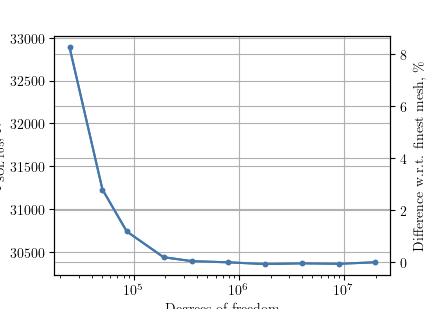

In [3]:
from pyNastran.op2.op2 import read_op2  # import function to read op2 file

# Import helper modules
main_directory = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(main_directory)
from resources import box_beam_utils

# Define shell elements' lengths to be used for the mesh convergence study and print them to screen
target_element_lengths = np.geomspace(H/2, H_S/8, 10) # [m]

# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
dofs = np.empty(np.shape(target_element_lengths), dtype=int)
linear_buckling_loads = np.empty(np.shape(target_element_lengths))

# Iterate through the different target element lengths
for count, element_length in enumerate(target_element_lengths):
    # Generate mesh
    mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs_and_stiffeners(
        width=W, height=H, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
        stiffeners_height=H_S, element_length=element_length)
    nodes_connectivity_matrix = mesh.faces.reshape(-1, 5)[:, 1:]
    
    # Read op2 file
    input_name = f"sol_105_{len(nodes_connectivity_matrix)}_elements"
    op2_filepath = os.path.join(DATA_DIRECTORY_PATH, input_name + '.op2')
    sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    
    # Find number of degrees of freedom and critical buckling load
    constrained_nodes_ids = next(iter(sol_105_op2.spcs.values()))[0].node_ids
    dofs[count] = (len(sol_105_op2.nodes) - len(constrained_nodes_ids))*6
    linear_buckling_loads[count] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
    
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
fig, ax1 = plt.subplots(figsize=(TEXTWIDTH_INCHES*.7, TEXTWIDTH_INCHES*.5))  # create a figure and set of axes
buckling_load_line = ax1.semilogx(dofs, linear_buckling_loads, 'o-')

# Create a twin set of axes to plot percentage difference vs degrees of freedom
ax2 = ax1.twinx()
percentage_diff = (linear_buckling_loads/linear_buckling_loads[-1]-1)*100
percentage_diff_line = ax2.plot(dofs, percentage_diff, 'o-')

# Print degrees of freedom, linear buckling loads and percentage differences to screen
np.set_printoptions(precision=3, suppress=True)
print("Degrees of freedom: ", dofs)
print("Linear buckling loads: ", linear_buckling_loads)
print("Percentage differences: ", percentage_diff)

# Set axes labels and grid
ax1.set_xlabel("Degrees of freedom")
ax1.set_ylabel("$P_\mathrm{SOL\,105}$, N")
ax2.set_ylabel("Difference w.r.t. finest mesh, \%")
ax1.grid(True)
ax2.grid(True)

# Show plot and save figure
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "MeshConvergence.pdf"), bbox_inches='tight', pad_inches=0)

Plot critical buckling mode of converged mesh.

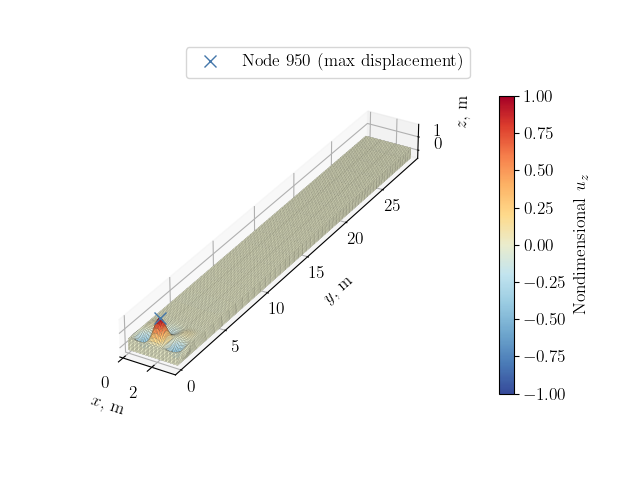

In [4]:
from resources import plot_utils

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=25)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 90  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .62))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.07, .18))  # move colorbar upwards

# Plot buckling mode
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE/0.8,
                     'lines.markersize': 8})
input_name = f"sol_105_33120_elements"
op2_filepath = os.path.join(DATA_DIRECTORY_PATH, input_name + '.op2')
sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
amplification_factor = 1.5  # amplification factor for displacements
clim = [-1, 1]  # colorbar limits
fig, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component="tz", colormap="sunset", length_unit='m',
    displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3, clim=clim)

# Plot node where maximum displacement occurs
root_node_id = plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2, displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3)
ax.legend(bbox_to_anchor=(.93, .92))

# Adjust plot and show it
adjust_3d_plot(ax, cbar)
plt.show()

# Save figure
BBOX_COLORBAR = fig.bbox_inches.from_bounds(.8, .5, 5.2, 3.9)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"InitialCriticalBucklingMode.pdf"), bbox_inches=BBOX_COLORBAR, pad_inches=0)

# Restore default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE,
                     'lines.markersize': DEFAULT_MARKER_SIZE})

Plot mesh convergence verification.

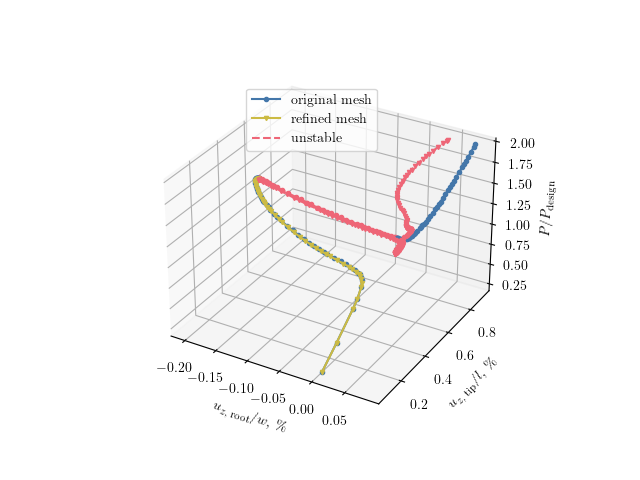

In [5]:
from resources import pynastran_utils

# Define dictionary with names of input files
input_name_dict = {"original mesh": "33120_elements",
                    "refined mesh": "108276_elements"}

# Initialize dictionaries to store ids of nodes where max displacement occurs and tip nodes
tip_node_xyz = np.array([W/2, L, 0])  # [mm] tip node coordinates
root_node_id_dict = {}  # dictionary to store ids of nodes where max displacement occurs
tip_node_id_dict = {}  # dictionary to store ids of tip nodes

# Initialize dictionaries to store eigenvalues and nondimensional loads and displacements
design_load = 30438.  # [N]
eigenvalues_dict = {}  # dictionary to store eigenvalues
nondimensional_loads_dict = {}  # dictionary to store nondimensional loads
nondimensional_displacements_dict = {}  # dictionary to store nondimensional displacements

# Create 3D plot of equilibrium diagram
fig = plt.figure()  # create a figure
ax_3d = plt.axes(projection="3d")  # create 3D axes
stable_lines = []  # list to store proxy artists for the legend
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")

# Iterate over the different meshes
for count, key in enumerate(input_name_dict):
    # Read op2 file of linear buckling analysis
    op2_filepath = os.path.join(DATA_DIRECTORY_PATH, f"sol_105_{input_name_dict[key]}.op2")
    sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

    # Find node where max displacement occurs
    max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
    root_node_id_dict[key] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]  # find id of node with max displacement magnitude
    
    # Find tip node id
    nodes_xyz_array = np.array([node.xyz for node in sol_105_op2.nodes.values()])  # get nodes' coordinates
    tip_node_id_dict[key] = np.argmin(np.linalg.norm(nodes_xyz_array - tip_node_xyz, axis=1)) + 1  # find id of tip node

    # Read op2 file of nonlinear analysis
    op2_filepath = os.path.join(DATA_DIRECTORY_PATH, f"sol_106_{input_name_dict[key]}.op2")
    sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    
    # Read load-displacement history
    _, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2, node_ids=[root_node_id_dict[key], tip_node_id_dict[key]])
    
    # Read eigenvalues
    f06_filepath = os.path.join(DATA_DIRECTORY_PATH, f"sol_106_{input_name_dict[key]}.f06")  # path of f06 file
    eigenvalues_dict[key] = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read eigenvalues from f06 file

    # Nondimensionalize loads and displacements
    nondimensional_loads_dict[key] = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load
    nondimensional_displacements_dict[key] = {"root": displacements[root_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W,
                                    "tip": displacements[tip_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L}

    # Plot load-displacement curve
    plot_utils.plot_3d_load_displacements_stability(axes=ax_3d,
                                                    displacements1=nondimensional_displacements_dict[key]["root"]*100,
                                                    displacements2=nondimensional_displacements_dict[key]["tip"]*100,
                                                    loads=nondimensional_loads_dict[key],
                                                    eigenvalues=eigenvalues_dict[key],
                                                    marker=MARKERS[count], color=COLORS[count])
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[count], color=COLORS[count], label=key))  # create proxy artist for the legend

# Add proxy artist for unstable lines and create legend
fig.legend(handles=stable_lines + [unstable_line], bbox_to_anchor=(0.6, 0.83))

# Set axes labels and grid
ax_3d.set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
ax_3d.set_ylabel("$u_{z,\,\mathrm{tip}}/l$, \%")
ax_3d.set_zlabel("$P/P_\mathrm{design}$")
ax_3d.grid(visible=True)

# Show plot and save figure
plt.show()
bounding_box = fig.bbox_inches.from_bounds(1.4, .4, 4.3, 3.7)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "MeshConvergenceVerification.pdf"), bbox_inches=bounding_box, pad_inches=0)

## Nonlinear Response of Initial Structure

Compare linear buckling loads obtained with the different load introduciton methods.

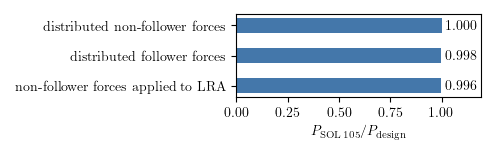

Percentage differences of linear buckling loads w.r.t. distributed non-follower result:
- distributed follower forces --> -0.2%
- non-follower forces applied to LRA --> -0.4%



In [6]:
# Initialize dictionary with names of input files
sol_105_input_name_dict = {"distributed non-follower forces": "sol_105_non_follower_linear_opt_start",
                           "distributed follower forces": "sol_105_follower_linear_opt_start",
                           "non-follower forces applied to LRA": "sol_105_lra_linear_opt_start"}

# Read linear buckling load for each analysis
linear_buckling_loads = []
for input_name in sol_105_input_name_dict.values():
     op2_filepath = os.path.join(DATA_DIRECTORY_PATH, input_name + '.op2')
     sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
     linear_buckling_loads.append(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0])

# Plot bar chart with linear buckling loads
fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES*.8, TEXTWIDTH_INCHES*.25))
y_pos = np.arange(len(sol_105_input_name_dict.keys()))  # position of bars
p = ax.barh(y_pos, linear_buckling_loads, height=0.5)  # plot bars
ax.bar_label(p, padding=3, fmt="{:,.3f}")  # add labels to bars
ax.set_yticks(y_pos, labels=tuple(sol_105_input_name_dict.keys()))  # set labels of y-axis
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("$P_\mathrm{SOL\,105}/P_\mathrm{design}$")  # set label of x-axis
ax.set_xlim(right=1.19)  # set limits of x-axis

# Save figure
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LoadIntroductionLinearBucklingBarChart.pdf"), bbox_inches='tight', pad_inches=0)

# Calculate percentage differences w.r.t. distributed non-follower forces
print(f"""Percentage differences of linear buckling loads w.r.t. distributed non-follower result:
- distributed follower forces --> {100*(linear_buckling_loads[1]-linear_buckling_loads[0])/linear_buckling_loads[0]:.1f}%
- non-follower forces applied to LRA --> {100*(linear_buckling_loads[2]-linear_buckling_loads[0])/linear_buckling_loads[0]:.1f}%
""")

Compare root bending moment obtained with the different load introduciton methods.

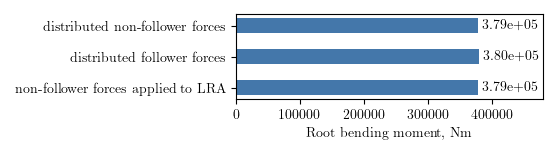

Percentage differences of root bending moments w.r.t. distributed non-follower result:
- distributed follower forces --> 0.23%
- non-follower forces applied to LRA --> 0.00%



In [7]:
def read_rbm_from_f06(f06_path):
    with open(f06_path, 'r') as file:
        # Flag to indicate if we are in the relevant section
        in_relevant_section = False
        # Loop through the lines of the file
        for line in file:
            # Check if the line indicates the start of the relevant section
            if 'SUBCASE/' in line:
                in_relevant_section = True
            # Once we are in the relevant section, look for the row starting with FZ
            if in_relevant_section and line.startswith('               FZ'):
                # Split the line into parts
                parts = line.split()
                # The R1 value is the 4th number from the end
                r1_value = parts[-3]
                return float(r1_value)
            # If we encounter the word 'TOTALS', it means we are past the section of interest
            if 'TOTALS' in line:
                in_relevant_section = False
    # Return None if the value is not found
    return None

# Read root bending moment for each analysis
root_bending_moments = []
for input_name in sol_105_input_name_dict.values():
    f06_filepath = os.path.join(DATA_DIRECTORY_PATH, input_name + '.f06')
    root_bending_moments.append(read_rbm_from_f06(f06_filepath))

# Plot bar chart with linear buckling loads
fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES*.9, TEXTWIDTH_INCHES*.25))
y_pos = np.arange(len(sol_105_input_name_dict.keys()))  # position of bars
p = ax.barh(y_pos, np.array(root_bending_moments)/1e3, height=0.5)  # plot bars
ax.bar_label(p, padding=3, fmt="{:,.2e}")  # add labels to bars
ax.set_yticks(y_pos, labels=tuple(sol_105_input_name_dict.keys()))  # set labels of y-axis
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Root bending moment, Nm")  # set label of x-axis
ax.set_xlim(right=4.8e5)  # set limits of x-axis

# Save figure
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "RootBendingMomentBarChart.pdf"), bbox_inches='tight', pad_inches=0)

# Calculate percentage differences w.r.t. distributed non-follower forces
print(f"""Percentage differences of root bending moments w.r.t. distributed non-follower result:
- distributed follower forces --> {100*(root_bending_moments[1]-root_bending_moments[0])/root_bending_moments[0]:.2f}%
- non-follower forces applied to LRA --> {100*(root_bending_moments[2]-root_bending_moments[0])/root_bending_moments[0]:.2f}%
""")

Comparison of nonlinear structural stability response of initial structure.

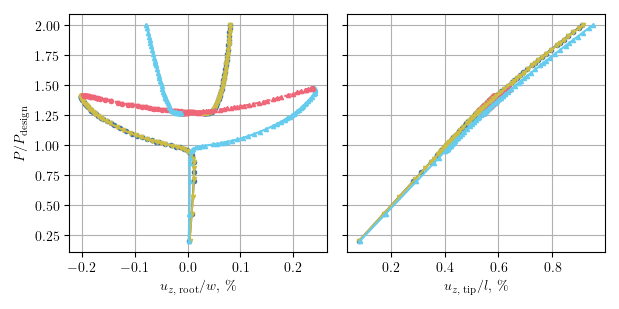

In [8]:
from resources import pynastran_utils

# Find id of tip node
tip_node_xyz = np.array([W/2, L, 0])  # tip node is taken at the center of the tip rib
nodes_xyz_array = np.array([sol_105_op2.nodes[i].xyz for i in sol_105_op2.nodes])
tip_node_id = np.argmin(np.linalg.norm(nodes_xyz_array - tip_node_xyz, axis=1)) + 1

# Initialize dictionary with names of input files
input_name_dict = {"distributed non-follower forces": "sol_106_33120_elements",
                   "distributed follower forces": "sol_106_follower_linear_opt_start",
                   "non-follower forces applied to LRA": "sol_106_lra_linear_opt_start"}

def plot_load_displacement_diagram(input_name_dict, max_nondimensional_load=1):
    # Create one figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(TEXTWIDTH_INCHES, TEXTWIDTH_INCHES*.5))
    stable_lines = []

    # Read eigenvalues, load and displacement histories and plot load-displacement diagrams
    eigenvalues_dict = {}
    sol_106_op2_dict = {}
    nondimensional_loads_dict = {}
    for count, (key, input_name) in enumerate(input_name_dict.items()):

        # Read eigenvalues
        f06_path = os.path.join(DATA_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
        eigenvalues_dict[key] =pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

        # Read load and displacement histories
        sol_106_op2_dict[key] = read_op2(os.path.join(DATA_DIRECTORY_PATH, input_name + '.op2'), load_geometry=True, debug=None)
        _, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
            op2=sol_106_op2_dict[key], node_ids=[root_node_id, tip_node_id])
        nondimensional_loads_dict[key] = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load
        
        # Plot applied load vs root displacement
        last_plot_index = np.argmin(np.abs(nondimensional_loads_dict[key] - max_nondimensional_load)) + 1  # limit plot to applied loads less than or equal to design load
        if last_plot_index > eigenvalues_dict[key].shape[1]:
            last_plot_index -= 1
        plot_utils.plot_2d_load_displacements_stability(
            axes[0],
            displacements[root_node_id][FIRST_SUBCASE_ID][:last_plot_index, Z_COMPONENT_INDEX]/W*100,
            nondimensional_loads_dict[key][:last_plot_index],
            eigenvalues_dict[key][:, :last_plot_index],
            MARKERS[count], COLORS[count])
        stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[count], color=COLORS[count], label=key))

        # Plot applied load vs tip displacement
        plot_utils.plot_2d_load_displacements_stability(
            axes[1],
            displacements[tip_node_id][FIRST_SUBCASE_ID][:last_plot_index, Z_COMPONENT_INDEX]/L*100,
            nondimensional_loads_dict[key][:last_plot_index],
            eigenvalues_dict[key][:, :last_plot_index],
            MARKERS[count], COLORS[count])
        
    # Return 
    return fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_loads_dict

# Plot load-displacement diagrams
fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_loads_dict = plot_load_displacement_diagram(
    input_name_dict, max_nondimensional_load=2)

# Create proxy artists for unstable segments
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")

# Set plot appearance for the first subplot
axes[0].set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

# Save figure
plt.tight_layout()  # Ensures proper spacing between subplots
axes[0].legend(handles=stable_lines + [unstable_line], loc="upper left",
               ncols=2, bbox_to_anchor=(-.03, 1.25), frameon=False)  # add legend after tight_layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LoadIntroductionInitialLoadDisplacementDiagram.pdf"), bbox_inches='tight', pad_inches=0)

Compare applied load at first limit point.

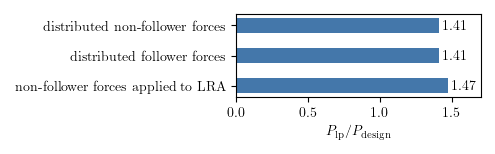

Percentage differences of limit point loads w.r.t. distributed non-follower result:
- distributed follower forces --> -0.1%
- non-follower forces applied to LRA --> 4.3%



In [9]:
# Find limit point load for each analysis
first_negative_eigenvalue_index_dict = {}
limit_point_loads = []
for key in sol_105_input_name_dict:
    first_negative_eigenvalue_index_dict[key] = np.where(eigenvalues_dict[key][0] < 0)[0][0]  # find index of first negative eigenvalue
    limit_point_loads.append(np.mean(
        nondimensional_loads_dict[key][first_negative_eigenvalue_index_dict[key] - 1:first_negative_eigenvalue_index_dict[key] + 1]))  # calculate nondimensional applied load at limit point as the mean between the last stable and first unstable load

# Plot bar chart with limit point loads
fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES*.8, TEXTWIDTH_INCHES*.25))
y_pos = np.arange(len(sol_105_input_name_dict.keys()))  # position of bars
p = ax.barh(y_pos, limit_point_loads, height=0.5)  # plot bars
ax.bar_label(p, padding=3, fmt="{:,.2f}")  # add labels to bars
ax.set_yticks(y_pos, labels=tuple(sol_105_input_name_dict.keys()))  # set labels of y-axis
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("$P_\mathrm{lp}/P_\mathrm{design}$")  # set label of x-axis
ax.set_xlim(right=1.7)  # set limits of x-axis

# Save figure
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LoadIntroductionLimitPointLoadBarChart.pdf"), bbox_inches='tight', pad_inches=0)

# Calculate percentage differences w.r.t. distributed non-follower forces
print(f"""Percentage differences of limit point loads w.r.t. distributed non-follower result:
- distributed follower forces --> {100*(limit_point_loads[1]-limit_point_loads[0])/limit_point_loads[0]:.1f}%
- non-follower forces applied to LRA --> {100*(limit_point_loads[2]-limit_point_loads[0])/limit_point_loads[0]:.1f}%
""")

Compare deformation under distributed non-follower forces vs non-follower forces applied to LRA under limit point load.

Deformation under distributed non-follower forces


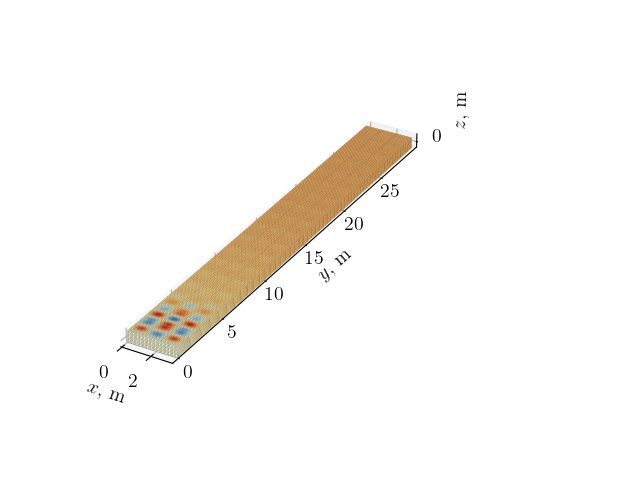

Deformation under non-follower forces applied to LRA


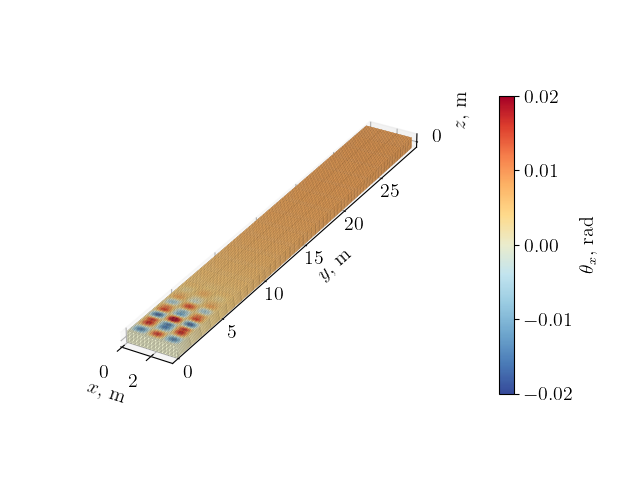

In [10]:
# Plot deformation under distributed non-follower forces
key = "distributed non-follower forces"
print(f"Deformation under {key}")
clim = [-.02, .02]  # color limits for deformation plot
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/.7)})
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=first_negative_eigenvalue_index_dict[key], clim=clim,
    displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3)
adjust_3d_plot(ax, cbar)
ax.set_zticks([0])
cbar.remove()
plt.show()
BBOX_NO_COLORBAR = fig.bbox_inches.from_bounds(.8, .5, 4., 3.9)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"deformation_{key.replace(' ', '_')}.pdf"), bbox_inches=BBOX_NO_COLORBAR, pad_inches=0)

# Plot deformation under non-follower forces applied to LRA
key = "non-follower forces applied to LRA"
print(f"Deformation under {key}")
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=first_negative_eigenvalue_index_dict[key], clim=clim,
    displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3)
adjust_3d_plot(ax, cbar)
ax.set_zticks([0])
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"deformation_{key.replace(' ', '_')}.pdf"), bbox_inches=BBOX_COLORBAR, pad_inches=0)

# Restore default font size
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

Compare deformation before and after snap-through for the case with distributed non-follower forces.

Deformation before snap:


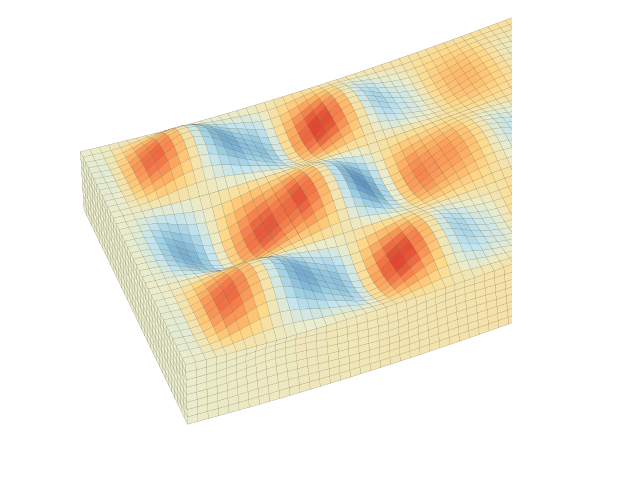

Deformation just after snap


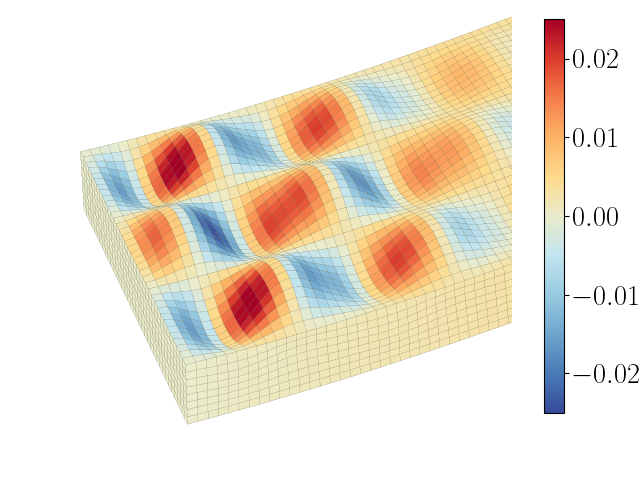

In [11]:
# Increase font size because figures are rendered side by side in the paper
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/.49)})

# Plot deformation just before limit point
key = "distributed non-follower forces"
print("Deformation before snap:")
amplification_factor = 50  # amplification factor for displacements
clim = [-.025, .025]  # color limits for deformation plot
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=first_negative_eigenvalue_index_dict[key], displacement_component='rx',
    colormap='sunset', length_unit='m', unit_scale_factor=1e-3, clim=clim, displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.remove()
ax.set_xlim(0, W*1e-3)
ax.set_ylim(0, 4*H*1e-3)
ax.set_zlim(-H/2*1e-3, H*1e-3)
ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f"get_{a}lim")() for a in 'xyz')])
plt.axis('off')
ax.view_init(40, -20)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "BeforeSnap.pdf"), bbox_inches='tight', pad_inches=0)

# Plot deformation just after snap
skip = 10  # number of increments to skip for selection of applied load after snap
subsequent_values = nondimensional_loads_dict[key][first_negative_eigenvalue_index_dict[key] + skip:]  # consider only applied loads after snap
closest_index_in_subsequent = np.argmin(np.abs(limit_point_loads[0] - subsequent_values))  # find index of closest value to applied load at first limit point
closest_index = first_negative_eigenvalue_index_dict[key] + skip + closest_index_in_subsequent  # sum found index to index of first negative eigenvalue
print("Deformation just after snap")
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=closest_index + 1, displacement_component='rx', colormap='sunset', length_unit='m',
    unit_scale_factor=1e-3, displacement_amplification_factor=amplification_factor, clim=clim)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .82))  # decrease colorbar size
cbar.ax.set_position(cbar.ax.get_position().translated(0, .14))  # move colorbar upwards
ax.set_xlim(0, W*1e-3)
ax.set_ylim(0, 4*H*1e-3)
ax.set_zlim(-H/2*1e-3, H*1e-3)
ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f"get_{a}lim")() for a in 'xyz')])
plt.axis('off')
ax.view_init(40, -20)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "AfterSnap.pdf"), bbox_inches='tight', pad_inches=0)

# Restore default font size
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

### Optimization with distributed non-follower forces <a name="distributed"></a>

Plot history of optimization with linear constraints.

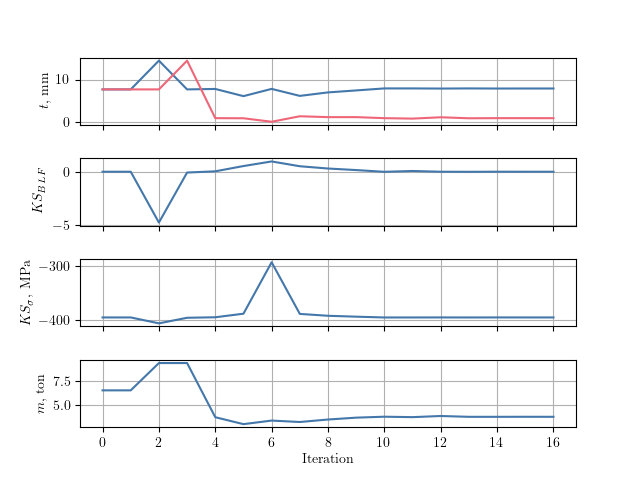

Design variables, constraints and objective at last iteration:
- interp.t_cp: [7.912 0.993]
- nastran_solver.ks_buckling: [0.]
- nastran_solver.ks_stress: [-395.434]
- nastran_solver.mass: [3.77]
Mass reduction: -42.2%


In [12]:
from resources import optimization_utils

recorder_filename = "sol_105_non_follower_linear_opt.sql"
recorder_filepath = os.path.join(DATA_DIRECTORY_PATH, recorder_filename)
fig, sol_105_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
mass_reduction = 100*(sol_105_opt_histories['nastran_solver.mass'][-1, 0] - sol_105_opt_histories['nastran_solver.mass'][0, 0])/\
    sol_105_opt_histories['nastran_solver.mass'][0, 0]
print(f"Mass reduction: {mass_reduction:.1f}%")
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "NonFollowerLinearOptHistory.pdf"), bbox_inches='tight', pad_inches=0)

Plot history of optimization with nonlinear constraints.

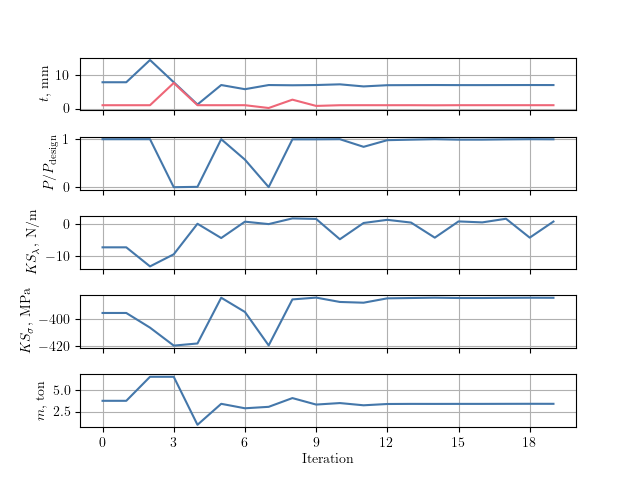

Design variables, constraints and objective at last iteration:
- interp.t_cp: [7.066 1.   ]
- nastran_solver.applied_load: [0.998]
- nastran_solver.ks_stability: [0.809]
- nastran_solver.ks_stress: [-383.985]
- nastran_solver.mass: [3.415]


In [13]:
recorder_filename = "sol_106_non_follower_nonlinear_opt.sql"
recorder_filepath = os.path.join(DATA_DIRECTORY_PATH, recorder_filename)
fig, sol_106_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "NonFollowerNonlinearOptHistory.pdf"), bbox_inches='tight', pad_inches=0)

Find final mass at last feasible iteration.

In [14]:
initial_mass = sol_105_opt_histories["nastran_solver.mass"][0, 0]*1e3
feasible_design_index = np.where(sol_106_opt_histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
final_masses = {"linear constraint": (sol_105_opt_histories["nastran_solver.mass"][-1, 0]*1e3,),
                "nonlinear constraint": (sol_106_opt_histories["nastran_solver.mass"][feasible_design_index, 0]*1e3,)}  # convert mass to kg
mass_reduction = 100*(sol_106_opt_histories['nastran_solver.mass'][feasible_design_index, 0]/sol_106_opt_histories['nastran_solver.mass'][0, 0] - 1)
print(f"Mass reduction: {mass_reduction:.1f}%")

Mass reduction: -9.3%


Plot bar chat of final thicknesses.

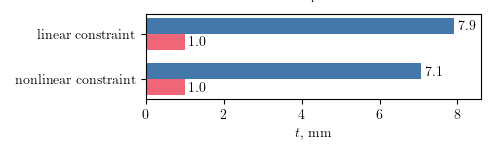

In [15]:
# Define function to plot bar chart of final thicknesses
def plot_thickness_bar_chart(sol_105_opt_histories, sol_106_opt_histories, figure_filename, iter_index=-1):
    # Set up data for the bar chart
    optimizations = ("linear constraint", "nonlinear constraint")
    final_thicknesses = {
        "$t_\mathrm{root}$": (sol_105_opt_histories["interp.t_cp"][-1, 0], sol_106_opt_histories["interp.t_cp"][iter_index, 0]),
        "$t_\mathrm{tip}$": (sol_105_opt_histories["interp.t_cp"][-1, 1], sol_106_opt_histories["interp.t_cp"][iter_index, 1])
    }

    # Plot bar chart with final thicknesses
    y_pos = np.arange(len(optimizations))  # the label locations
    height = 0.35  # the height of the bars
    multiplier = .5  # multiplier to separate bars
    fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES*.8, TEXTWIDTH_INCHES*.25))  # create figure and axis
    for attribute, values in final_thicknesses.items():  # iterate over attributes and values
        offset = height * multiplier  # offset to separate bars
        rects = ax.barh(y_pos + offset, values, height, label=attribute)  # plot bars
        ax.bar_label(rects, padding=3, fmt="{:,.1f}")  # add labels to bars
        multiplier += 1  # increase multiplier to separate bars

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("$t$, mm")
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_yticks(y_pos + height, optimizations)
    ax.set_xlim(right=8.6)  # set limits of x-axis

    # Save figure
    plt.tight_layout()  # ensures proper spacing between subplots
    ax.legend(bbox_to_anchor=(0.03, 1.01), ncols=2, frameon=False)  # add legend after tight layout
    plt.show()
    fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, figure_filename + '.pdf'), bbox_inches='tight', pad_inches=0)

# Plot bar chart with final thicknesses
figure_name = "Non-followerThicknesses"
plot_thickness_bar_chart(sol_105_opt_histories, sol_106_opt_histories, figure_name)

Comparison of nonlinear structural stability response of initial structure vs linearly optimized structure vs nonlinearly optimized structure.

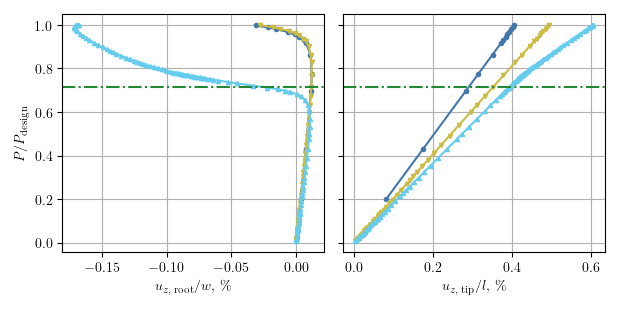

In [16]:
# Initialize dictionary with names of input files
input_name_dict = {"initial structure": "sol_106_33120_elements",
                   "linearly optimized structure": "sol_106_non_follower_linear_opt",
                   "nonlinearly optimized structure": "sol_106_non_follower_nonlinear_opt"}

# Plot load-displacement diagrams
fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_applied_loads_dict = plot_load_displacement_diagram(input_name_dict)

sol_105_input_name = "sol_105_non_follower_nonlinear_opt"
sol_105_op2 = read_op2(os.path.join(DATA_DIRECTORY_PATH, sol_105_input_name + '.op2'), load_geometry=True, debug=None)
buckling_load_factor = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
axes[0].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
axes[1].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="linear buckling of nonlinearly optimized structure")

# Set plot appearance for the first subplot
axes[0].set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

# Save figure
plt.tight_layout()  # ensures proper spacing between subplots
axes[0].legend(handles=stable_lines + [glass_ceiling_line], loc="upper left",
               ncols=2, bbox_to_anchor=(-.03, 1.25), frameon=False)  # add legend after tight_layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "Non-followerLoadDisplacementDiagram.pdf"), bbox_inches='tight', pad_inches=0)

Compare deformation at design load of linearly vs nonlinearly optimized structure.

Deformation of linearly optimized structure


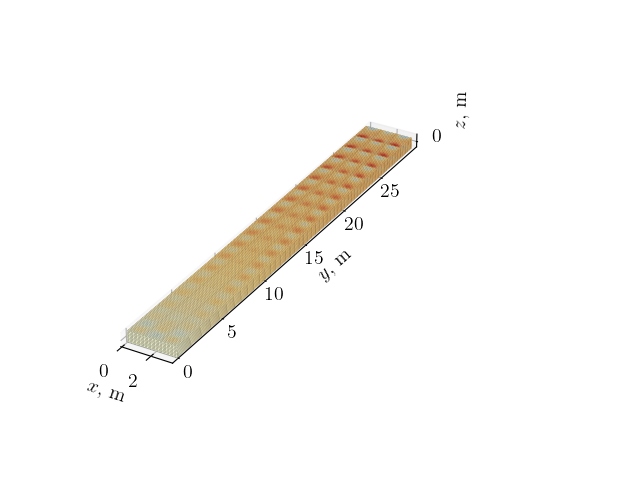

Deformation of nonlinearly optimized structure


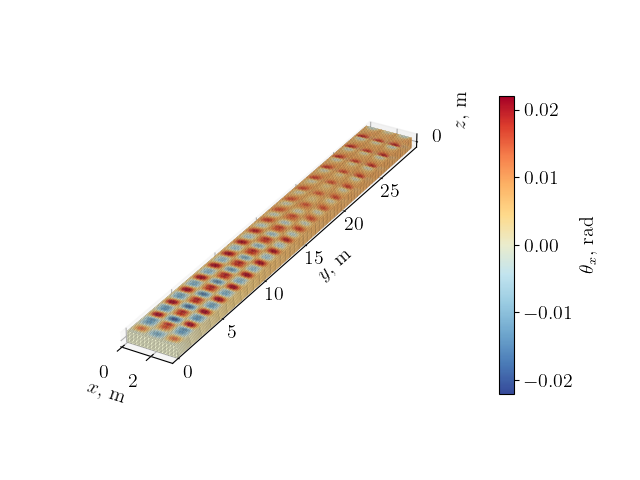

In [17]:
def plot_deformation_comparison(nondimensional_applied_loads_dict, sol_106_op2_dict, label):
    # Plot deformation of linearly optimized structure
    key = "linearly optimized structure"
    print(f"Deformation of {key}")
    clim = [-.022, .022]  # color limits for deformation plot
    increment_number = np.argmin(np.abs(nondimensional_applied_loads_dict[key] - 1)) + 1  # find number of closest converged increment to design load
    plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/.7)})
    fig, ax, cbar = plot_utils.plot_deformation(
        op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=increment_number, clim=clim,
        displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3)
    adjust_3d_plot(ax, cbar)
    ax.set_zticks([0])
    cbar.remove()
    plt.show()
    fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"{label}_deformation_{key.replace(' ', '_')}.pdf"), bbox_inches=BBOX_NO_COLORBAR, pad_inches=0)

    # Plot deformation of nonlinearly optimized structure
    key = "nonlinearly optimized structure"
    print(f"Deformation of {key}")
    fig, ax, cbar = plot_utils.plot_deformation(
        op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, clim=clim, displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3)
    adjust_3d_plot(ax, cbar)
    ax.set_zticks([0])
    plt.show()
    fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"{label}_deformation_{key.replace(' ', '_')}.pdf"), bbox_inches=BBOX_COLORBAR, pad_inches=0)

    # Restore default font size
    plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

label = "non-follower"
plot_deformation_comparison(nondimensional_applied_loads_dict, sol_106_op2_dict, label)

### Optimization with follower forces <a name="follower"></a>

Plot history of optimization with linear constraints.

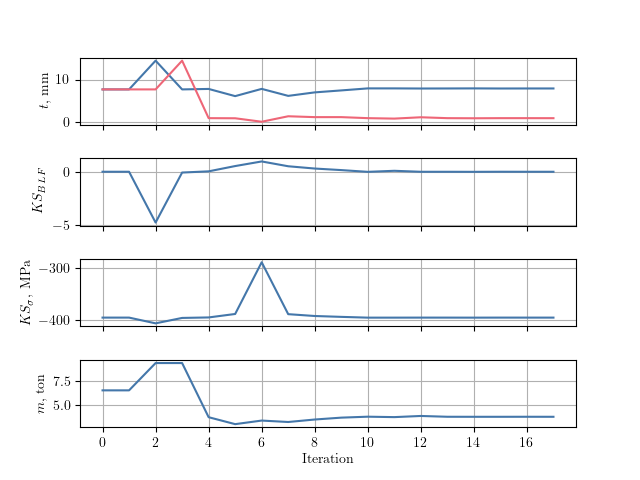

Design variables, constraints and objective at last iteration:
- interp.t_cp: [7.918 0.993]
- nastran_solver.ks_buckling: [0.]
- nastran_solver.ks_stress: [-395.392]
- nastran_solver.mass: [3.773]
Mass reduction: -42.1%


In [18]:
recorder_filename = "sol_105_follower_linear_opt.sql"
recorder_filepath = os.path.join(DATA_DIRECTORY_PATH, recorder_filename)
fig, sol_105_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
final_masses["linear constraint"] = final_masses["linear constraint"] + (sol_105_opt_histories["nastran_solver.mass"][-1, 0]*1e3,)  # convert mass to kg
mass_reduction = 100*(sol_105_opt_histories['nastran_solver.mass'][-1, 0] - sol_105_opt_histories['nastran_solver.mass'][0, 0])/\
    sol_105_opt_histories['nastran_solver.mass'][0, 0]
print(f"Mass reduction: {mass_reduction:.1f}%")
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "FollowerLinearOptHistory.pdf"), bbox_inches='tight', pad_inches=0)

Plot history of optimization with nonlinear constraints.

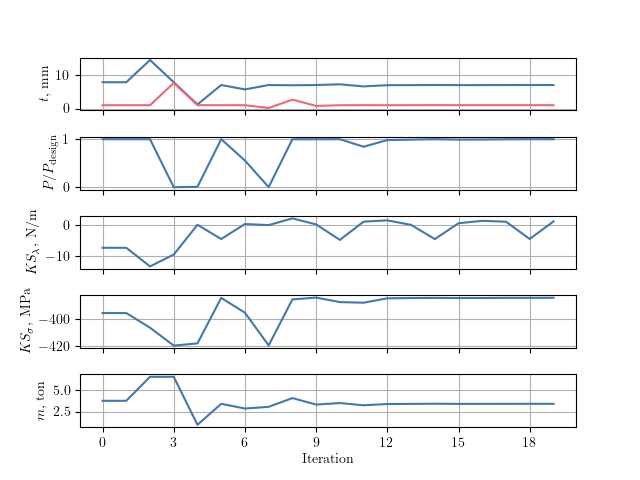

Design variables, constraints and objective at last iteration:
- interp.t_cp: [7.073 1.   ]
- nastran_solver.applied_load: [1.]
- nastran_solver.ks_stability: [1.197]
- nastran_solver.ks_stress: [-383.815]
- nastran_solver.mass: [3.417]


In [19]:
recorder_filename = "sol_106_follower_nonlinear_opt.sql"
recorder_filepath = os.path.join(DATA_DIRECTORY_PATH, recorder_filename)
fig, sol_106_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "FollowerNonlinearOptHistory.pdf"), bbox_inches='tight', pad_inches=0)

Find final mass at last feasible iteration.

In [20]:
feasible_design_index = np.where(sol_106_opt_histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
final_masses["nonlinear constraint"] = final_masses["nonlinear constraint"] +\
    (sol_106_opt_histories["nastran_solver.mass"][feasible_design_index, 0]*1e3,)  # convert mass to kg
mass_reduction = 100*(sol_106_opt_histories['nastran_solver.mass'][feasible_design_index, 0]/sol_106_opt_histories['nastran_solver.mass'][0, 0] - 1)
print(f"Mass reduction: {mass_reduction:.1f}%")

Mass reduction: -9.3%


Plot bar chat of final thicknesses.

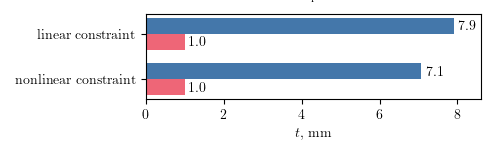

In [21]:
figure_name = "FollowerForcesThicknesses"
plot_thickness_bar_chart(sol_105_opt_histories, sol_106_opt_histories, figure_name)

Comparison of nonlinear structural stability response of initial structure vs linearly optimized structure vs nonlinearly optimized structure.

C:\Users\qa21944\AppData\Local\Temp\ipykernel_22456\514518452.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, sharey=True, figsize=(TEXTWIDTH_INCHES, TEXTWIDTH_INCHES*.5))


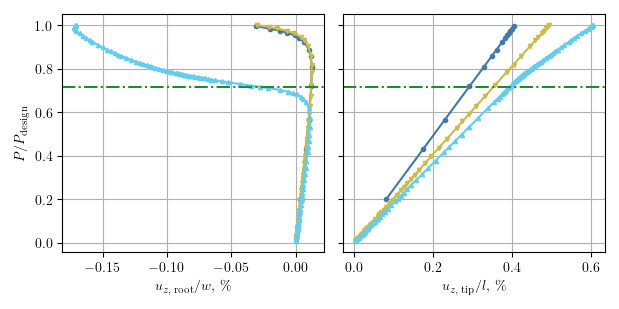

In [22]:
# Initialize dictionary with names of input files
input_name_dict = {"initial structure": "sol_106_follower_linear_opt_start",
                   "linearly optimized structure": "sol_106_follower_linear_opt",
                   "nonlinearly optimized structure": "sol_106_follower_nonlinear_opt"}

# Plot load-displacement diagrams
fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_applied_loads_dict = plot_load_displacement_diagram(input_name_dict)

sol_105_input_name = "sol_105_follower_nonlinear_opt"
sol_105_op2 = read_op2(os.path.join(DATA_DIRECTORY_PATH, sol_105_input_name + '.op2'), load_geometry=True, debug=None)
buckling_load_factor = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
axes[0].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
axes[1].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="linear buckling of nonlinearly optimized structure")

# Set plot appearance for the first subplot
axes[0].set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

# Save figure
plt.tight_layout()  # ensures proper spacing between subplots
axes[0].legend(handles=stable_lines + [glass_ceiling_line], loc="upper left",
               ncols=2, bbox_to_anchor=(-.03, 1.25), frameon=False)  # add legend after tight_layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "FollowerForcesLoadDisplacementDiagram.pdf"), bbox_inches='tight', pad_inches=0)

Compare deformation at design load of linearly vs nonlinearly optimized structure.

Deformation of linearly optimized structure


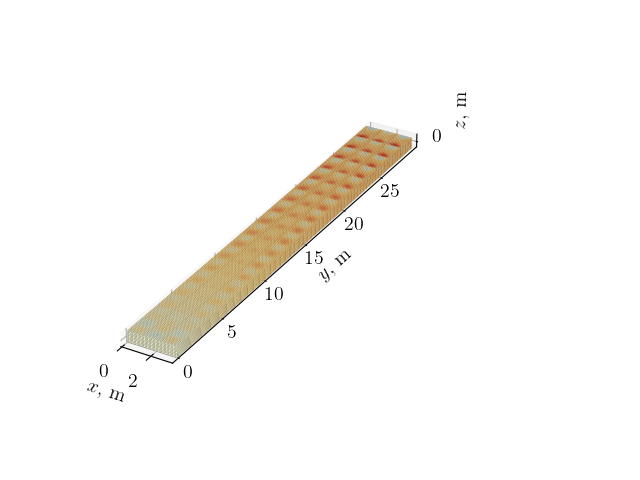

Deformation of nonlinearly optimized structure


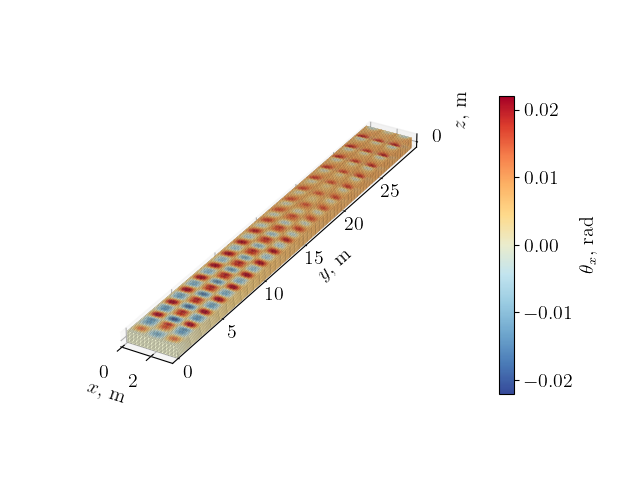

In [23]:
label = "follower"
plot_deformation_comparison(nondimensional_applied_loads_dict, sol_106_op2_dict, label)

### Optimization with non-follower forces applied to load reference axis <a name="reference-axis"></a>

Plot history of optimization with linear constraints.

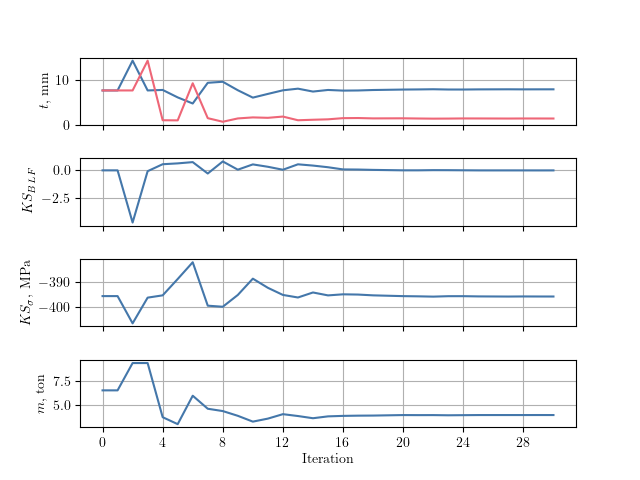

Design variables, constraints and objective at last iteration:
- interp.t_cp: [7.954 1.388]
- nastran_solver.ks_buckling: [0.]
- nastran_solver.ks_stress: [-395.838]
- nastran_solver.mass: [3.955]
Mass reduction: -39.3%


In [24]:
recorder_filename = "sol_105_lra_linear_opt.sql"
recorder_filepath = os.path.join(DATA_DIRECTORY_PATH, recorder_filename)
fig, sol_105_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
final_masses["linear constraint"] = final_masses["linear constraint"] + (sol_105_opt_histories["nastran_solver.mass"][-1, 0]*1e3,)  # convert mass to kg
mass_reduction = 100*(sol_105_opt_histories['nastran_solver.mass'][-1, 0] - sol_105_opt_histories['nastran_solver.mass'][0, 0])/\
    sol_105_opt_histories['nastran_solver.mass'][0, 0]
print(f"Mass reduction: {mass_reduction:.1f}%")
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LraLinearOptHistory.pdf"), bbox_inches='tight', pad_inches=0)

Plot history of optimization with nonlinear constraints.

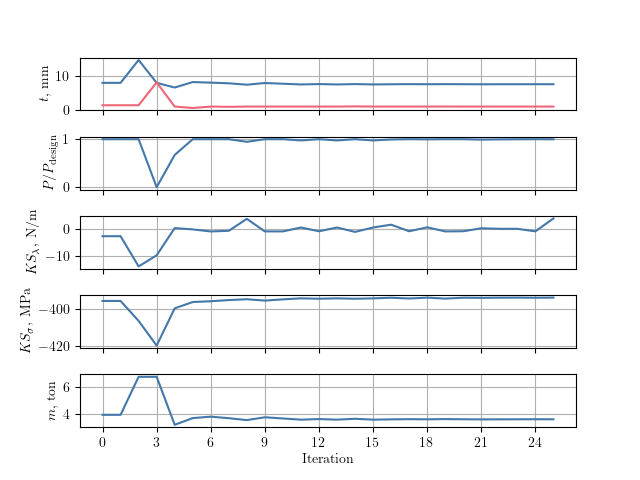

Design variables, constraints and objective at last iteration:
- interp.t_cp: [7.553 1.   ]
- nastran_solver.applied_load: [0.998]
- nastran_solver.ks_stability: [3.829]
- nastran_solver.ks_stress: [-393.947]
- nastran_solver.mass: [3.621]


In [25]:
recorder_filename = "sol_106_lra_nonlinear_opt.sql"
recorder_filepath = os.path.join(DATA_DIRECTORY_PATH, recorder_filename)
fig, sol_106_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LraNonlinearOptHistory.pdf"), bbox_inches='tight', pad_inches=0)

Find final mass at last feasible iteration.

In [26]:
feasible_design_index = np.where(sol_106_opt_histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
final_masses["nonlinear constraint"] = final_masses["nonlinear constraint"] +\
    (sol_106_opt_histories["nastran_solver.mass"][feasible_design_index, 0]*1e3,)  # convert mass to kg
mass_reduction = 100*(sol_106_opt_histories['nastran_solver.mass'][feasible_design_index, 0]/sol_106_opt_histories['nastran_solver.mass'][0, 0] - 1)
print(f"Mass reduction: {mass_reduction:.1f}%")

Mass reduction: -8.3%


Plot bar chat of final thicknesses.

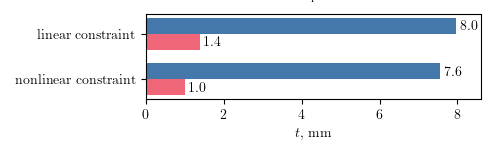

In [27]:
figure_name = "LRAThicknesses"
plot_thickness_bar_chart(sol_105_opt_histories, sol_106_opt_histories, figure_name, feasible_design_index)

Comparison of nonlinear structural stability response of initial structure vs linearly optimized structure vs nonlinearly optimized structure.

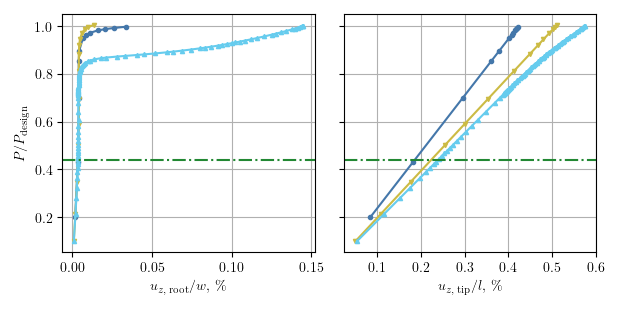

In [28]:
# Initialize dictionary with names of input files
input_name_dict = {"initial structure": "sol_106_lra_linear_opt_start",
                   "linearly optimized structure": "sol_106_lra_linear_opt",
                   "nonlinearly optimized structure": "sol_106_lra_nonlinear_opt"}

# Plot load-displacement diagrams
fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_applied_loads_dict = plot_load_displacement_diagram(input_name_dict)

sol_105_input_name = "sol_105_lra_nonlinear_opt"
sol_105_op2 = read_op2(os.path.join(DATA_DIRECTORY_PATH, sol_105_input_name + '.op2'), load_geometry=True, debug=None)
buckling_load_factor = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
axes[0].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
axes[1].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="linear buckling of nonlinearly optimized structure")

# Set plot appearance for the first subplot
axes[0].set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

# Save figure
plt.tight_layout()  # ensures proper spacing between subplots
axes[0].legend(handles=stable_lines + [glass_ceiling_line], loc="upper left",
               ncols=2, bbox_to_anchor=(-.03, 1.25), frameon=False)  # add legend after tight_layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LRALoadDisplacementDiagram.pdf"), bbox_inches='tight', pad_inches=0)

Compare deformation at design load of linearly vs nonlinearly optimized structure.

Deformation of linearly optimized structure


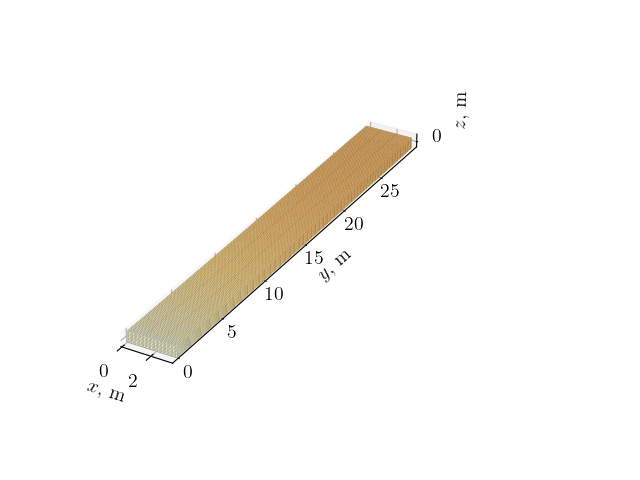

Deformation of nonlinearly optimized structure


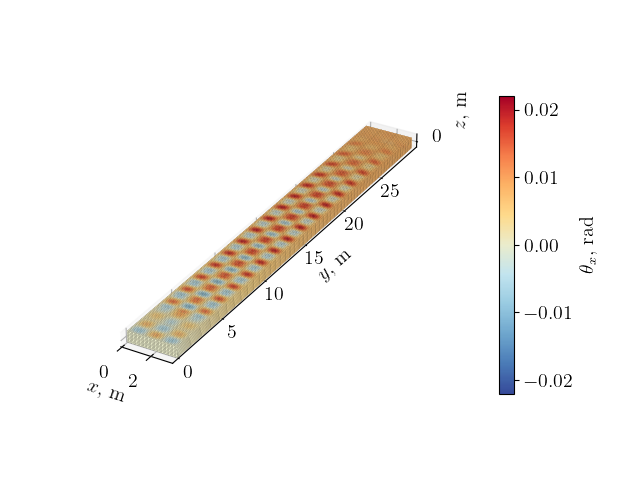

In [29]:
label = "lra"
plot_deformation_comparison(nondimensional_applied_loads_dict, sol_106_op2_dict, label)

### Comparative discussion <a name="comparative"></a>

Plot bar chart of final masses.

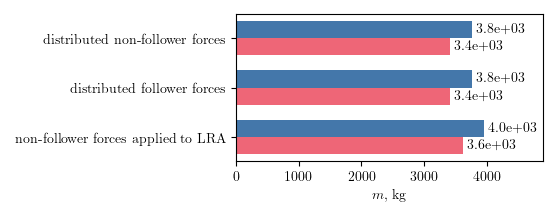

Percentage differences of final masses w.r.t. initial mass:
- distributed non-follower forces: -47.6%
- distributed follower forces: -47.5%
- non-follower forces applied to LRA: -44.4%



In [30]:
# Set up data for the bar chart
optimizations = ("distributed non-follower forces", "distributed follower forces", "non-follower forces applied to LRA")

# Plot bar chart with final thicknesses
y_pos = np.arange(len(optimizations))  # the label locations
height = 0.35  # the height of the bars
multiplier = .5  # multiplier to separate bars
fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES*.9, TEXTWIDTH_INCHES*.35))  # create figure and axis
for attribute, values in final_masses.items():  # iterate over attributes and values
    offset = height * multiplier  # offset to separate bars
    rects = ax.barh(y_pos + offset, values, height, label=attribute)  # plot bars
    ax.bar_label(rects, padding=3, fmt="{:,.1e}")  # add labels to bars
    multiplier += 1  # increase multiplier to separate bars

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("$m$, kg")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticks(y_pos + height, optimizations)
ax.set_xlim(right=4.9e3)  # set limits of x-axis

# Save figure
plt.tight_layout()  # ensures proper spacing between subplots
ax.legend(bbox_to_anchor=(0.05, 1.), ncols=2, frameon=False)  # add legend after tight layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "FinalMassesBarChart.pdf"), bbox_inches='tight', pad_inches=0)

# Calculate percentage differences w.r.t. initial mass
key = "nonlinear constraint"
print(f"""Percentage differences of final masses w.r.t. initial mass:
- distributed non-follower forces: {100*(final_masses[key][0] - initial_mass)/initial_mass:.1f}%
- distributed follower forces: {100*(final_masses[key][1] - initial_mass)/initial_mass:.1f}%
- non-follower forces applied to LRA: {100*(final_masses[key][2] - initial_mass)/initial_mass:.1f}%
""")